In [77]:
#!/usr/bin/env python
# encoding: utf-8
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

from train._main import *

import numpy as np
import matplotlib.pyplot as plt
import torch.fft as fft
import torch

from torch.autograd import Variable
from models._main import *
from preprocess._utils import *
import torch.nn as nn
import torch.utils.data as Data
import torch
from torch.optim import optimizer



class lstm(nn.Module):
    """
    INPUT_SIZE = seq_len
    HIDDEN_SIZE = up to you
    LAYERS = number of lstm layers
    """
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, LAYERS, DROP_RATE):
        super(lstm, self).__init__()
        self.rnn = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=LAYERS,
            dropout=DROP_RATE,
            batch_first=True,
            # bidirectional=True,
        )
        self.hidden_out = nn.Linear(HIDDEN_SIZE, INPUT_SIZE)
        self.h_s = None
        self.h_c = None

    def forward(self, x):
        r_out, (h_s, h_c) = self.rnn(x)
        output = self.hidden_out(r_out)
        return output


/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_12787/1813064310.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_data = torch.tensor(


dict_keys(['dataset', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'residual_smooth_calcium', 'neuron_to_idx', 'idx_to_neuron', 'max_time', 'time_in_seconds', 'dt', 'named_neurons_mask', 'named_neuron_to_idx', 'idx_to_named_neuron', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons'])


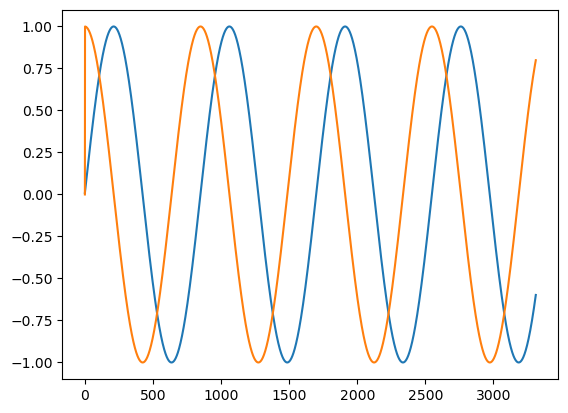

In [78]:
dataset = create_dataset(raw_data, raw_der)



print(dataset["worm0"].keys())

plt.plot(dataset["worm0"]["calcium_data"][:, 3])
plt.plot(dataset["worm0"]["residual_calcium"][:, 3])
# plt.legend(["cal", "res"], loc="upper right")
# plt.show()

# config = OmegaConf.load("conf/model.yaml")
# print("Model:", OmegaConf.to_yaml(config), end="\n\n")
# model = get_model(config)
#
# config = OmegaConf.load("conf/train.yaml")
# model, log_dir = train_model(model, dataset, config)

In [104]:
### quick trial on LSTM, model defined above
time_step = 10
# hyperparams
INPUT_SIZE = time_step
HIDDEN_SIZE = 50
EPOCH = 10
LR = 0.1  # learning rate
DROP_RATE = 0.2  # drop out
LAYERS = 2  # hidden layer
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [105]:
print(DEVICE)

cpu


In [106]:
torch.manual_seed(0)

model = lstm(INPUT_SIZE, HIDDEN_SIZE, LAYERS, DROP_RATE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = torch.nn.L1Loss()

worm_train = []
worm_test = []
for i in range(len(dataset)):
    worm = "worm" + str(i)
    slice = 100
    calcium_data = dataset[worm]["calcium_data"].float()[:slice]
    residual_calcium = dataset[worm]["residual_calcium"].float()[:slice]
    train_size = int(0.8 * slice)
    test_size = slice - train_size

    train_ca, test_ca = calcium_data.split(train_size, dim=0)
    train_res, test_res = residual_calcium.split(train_size, dim=0)
    train_batch_size = train_size // time_step
    test_batch_size = test_size // time_step
    train_ca = train_ca[:(train_ca.shape[0] // time_step * time_step)]
    test_ca = test_ca[:(test_ca.shape[0] // time_step * time_step)]
    train_res = train_res[:(train_res.shape[0] // time_step * time_step)]
    test_res = test_res[:(test_res.shape[0] // time_step * time_step)]

    train_dataset = Data.TensorDataset(train_ca, train_res)
    train_cal = Data.TensorDataset(train_ca, train_ca)
    test_dataset = Data.TensorDataset(test_ca, test_res)
    test_cal = Data.TensorDataset(test_ca, test_ca)
    train_loader = Data.DataLoader(
        dataset=train_dataset,
        batch_size=time_step,
        shuffle=True,
    )

    ca_train_loader = Data.DataLoader(
        dataset=train_cal,
        batch_size=time_step,
        shuffle=True,
    )

    test_loader = Data.DataLoader(
        dataset=test_dataset,
        batch_size=time_step,
        shuffle=True,
    )
    ca_test_loader = Data.DataLoader(
        dataset=test_cal,
        batch_size=time_step,
        shuffle=True,
    )
    # worm_train.append(ca_train_loader)
    # worm_test.append(ca_train_loader)
    worm_train.append(train_loader)
    worm_test.append(train_loader)

In [109]:
print("Start Training!")
# train
for i in range(len(dataset) - 5):
    print("--------worm " + "No. " + str(i) + "--------")
    train_loader = worm_train[i]
    test_loader = worm_test[i]
    train_base_loss_history = []
    train_pred_loss_history = []
    test_base_loss_history = []
    test_pred_loss_history = []
    for e in range(EPOCH):
        train_base_loss = 0
        train_pred_loss = 0
        test_base_loss = 0
        test_pred_loss = 0
        for X_train, Y_train in train_loader:
            X_train, Y_train = X_train.to(DEVICE), Y_train.to(DEVICE)
            X_train = X_train.transpose(1, -2)
            Y_train = Y_train.transpose(1, -2)
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(torch.zeros_like(Y_train), Y_train)
            Y_tr = model(X_train)  # Forward pass.
            loss = criterion(Y_tr, Y_train)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()  # Update parameters based on gradients.
            train_base_loss += base.detach().item()
            train_pred_loss += loss.detach().item()
        train_base_loss_history.append(train_base_loss / train_batch_size)
        train_pred_loss_history.append(train_pred_loss / train_batch_size)

        for X_test, Y_test in test_loader:
            X_test, Y_test = X_test.to(DEVICE), Y_test.to(DEVICE)
            X_test = X_test.transpose(1, -2)
            Y_test = Y_test.transpose(1, -2)
            optimizer.zero_grad()  # Clear gradients.
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(torch.zeros_like(Y_test), Y_test)
            Y_pred = model(X_test)  # Forward pass.
            loss = criterion(Y_pred, Y_test)
            test_base_loss += base.detach().item()
            test_pred_loss += loss.detach().item()
        test_base_loss_history.append(test_base_loss / test_batch_size)
        test_pred_loss_history.append(test_pred_loss / test_batch_size)

        print("epoch = {}, train_loss = {:.4f}, test_loss = {:.4f}".format(e,
                                                                           train_pred_loss_history[-1] -
                                                                           train_base_loss_history[
                                                                               -1],
                                                                           test_pred_loss_history[-1] -
                                                                           test_base_loss_history[
                                                                               -1]))

    delta_train = [train_pred_loss_history[i] - train_base_loss_history[i] for i in range(len(train_base_loss_history))]
    delta_test = [test_pred_loss_history[i] - test_base_loss_history[i] for i in range(len(test_base_loss_history))]
    plt.plot(delta_train)
    plt.plot(delta_test)
    plt.legend(["train", "test"])
    plt.ylabel("Loss-Baseline")
    plt.xlabel("Epoch")
    plt.title("Worm " + str(i) + ", Epoch: " + str(EPOCH) + ", Loss: L1")
    plt.show()

Start Training!
--------worm No. 0--------
epoch = 0, train_loss = -0.8975, test_loss = -3.5747
epoch = 1, train_loss = -0.8960, test_loss = -3.5929
epoch = 2, train_loss = -0.8974, test_loss = -3.5910
epoch = 3, train_loss = -0.8997, test_loss = -3.5877
epoch = 4, train_loss = -0.8978, test_loss = -3.5953
epoch = 5, train_loss = -0.8976, test_loss = -3.5933
epoch = 6, train_loss = -0.8965, test_loss = -3.5951
epoch = 7, train_loss = -0.8977, test_loss = -3.5886
epoch = 8, train_loss = -0.8982, test_loss = -3.5984
epoch = 9, train_loss = -0.8978, test_loss = -3.5867
epoch = 10, train_loss = -0.8980, test_loss = -3.6047
epoch = 11, train_loss = -0.8985, test_loss = -3.5855
epoch = 12, train_loss = -0.8962, test_loss = -3.5881
epoch = 13, train_loss = -0.8978, test_loss = -3.6030
epoch = 14, train_loss = -0.9001, test_loss = -3.5701
epoch = 15, train_loss = -0.8986, test_loss = -3.5893
epoch = 16, train_loss = -0.8972, test_loss = -3.5948
epoch = 17, train_loss = -0.8999, test_loss = -3.

KeyboardInterrupt: 

### Visualization of RES
here is the result with 50 epochs, the $\phi$(phi) is not learned well, so is the $A$(amplitude)

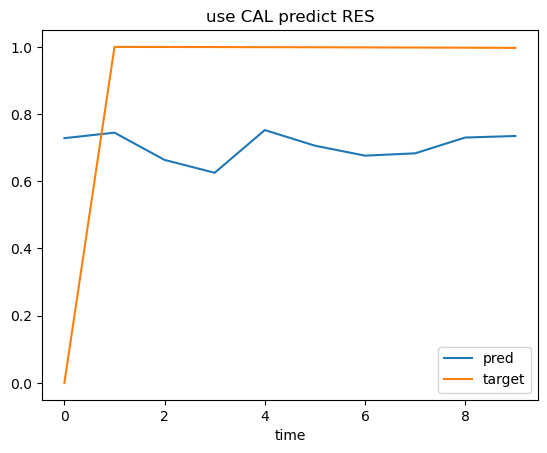

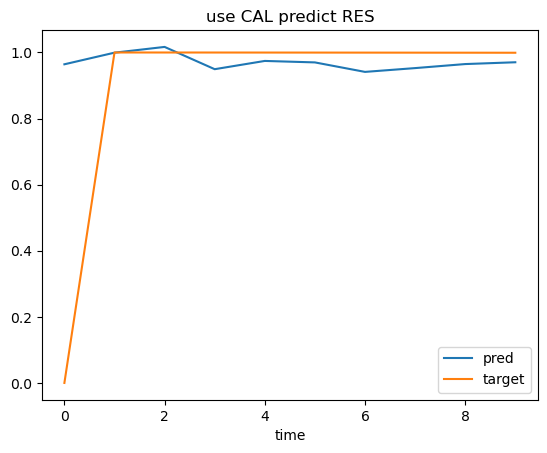

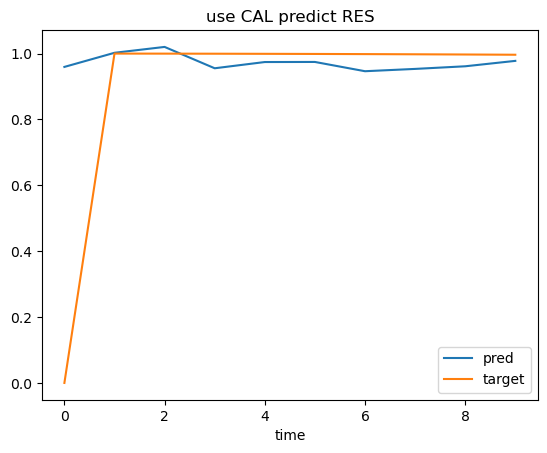

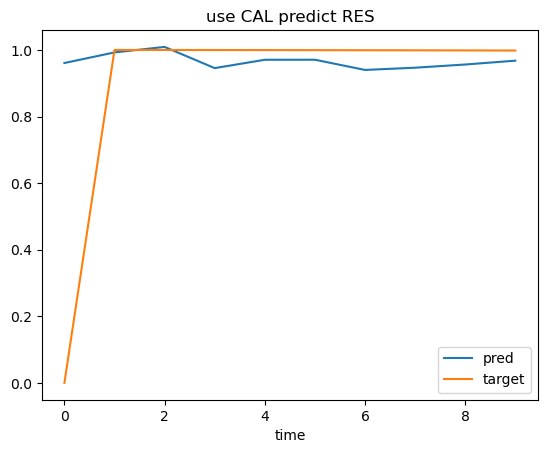

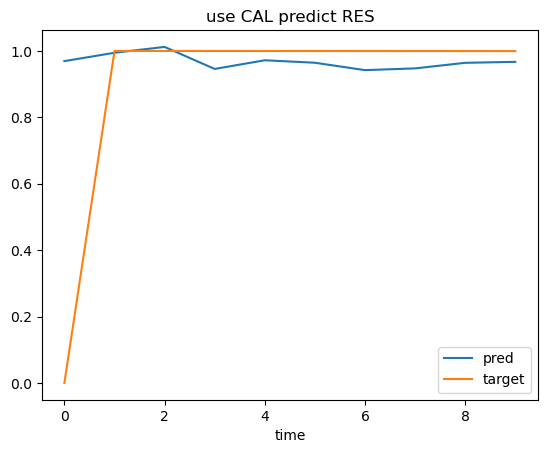

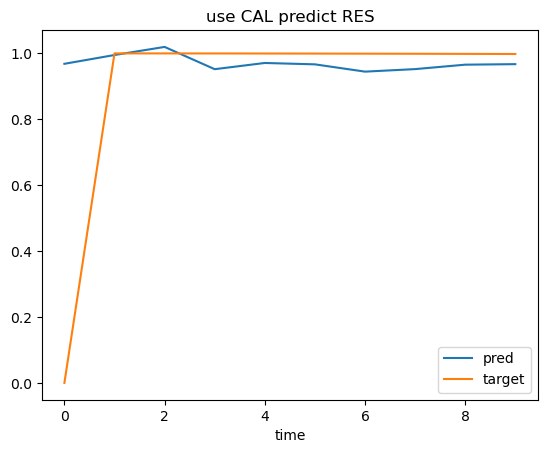

In [108]:
# prediction residual visualization (train on calcium - residual)
calcium_data = dataset["worm0"]["calcium_data"].float()[:slice // time_step]
residual_calcium = dataset["worm0"]["residual_calcium"].float()[:slice // time_step]
prediction = model(calcium_data.T)
prediction = prediction.T

plt.plot(prediction[:, 0].detach().numpy())
plt.plot(residual_calcium[:, 0])
plt.title("use CAL predict RES")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 10].detach().numpy())
plt.plot(residual_calcium[:, 10])
plt.title("use CAL predict RES")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 50].detach().numpy())
plt.plot(residual_calcium[:, 50])
plt.title("use CAL predict RES")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 100].detach().numpy())
plt.plot(residual_calcium[:, 100])
plt.title("use CAL predict RES")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 200].detach().numpy())
plt.plot(residual_calcium[:, 200])
plt.title("use CAL predict RES")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 300].detach().numpy())
plt.plot(residual_calcium[:, 300])
plt.title("use CAL predict RES")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

### Visualization on CAL
**this code block uses the LSTM model based on train: calcium_data, test: calcium_data**
you should change data_loader into ca_train_loader and ca_test_loader

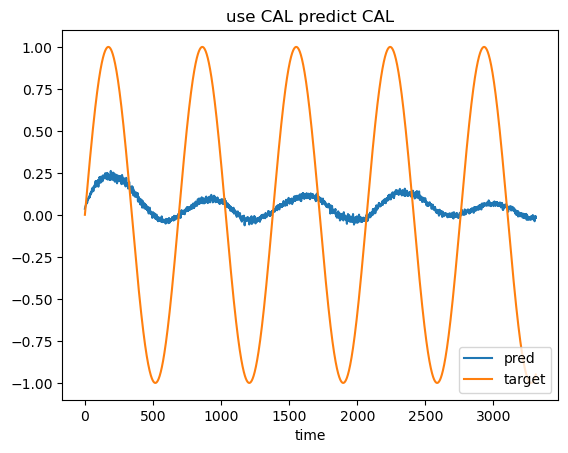

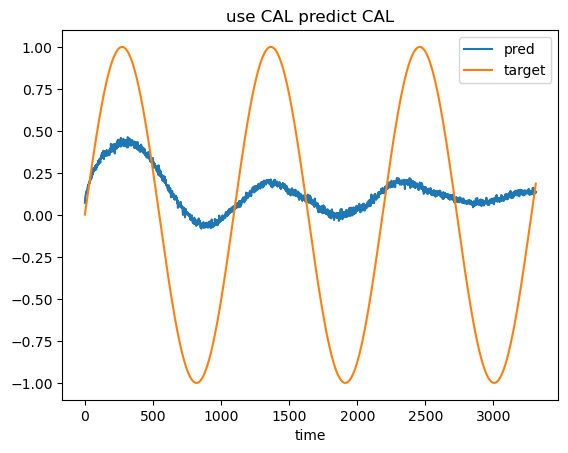

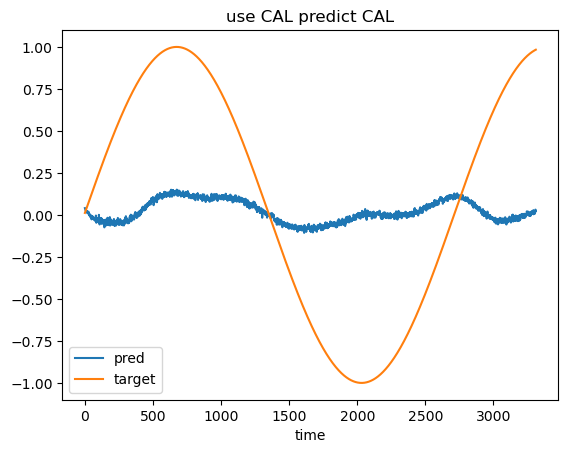

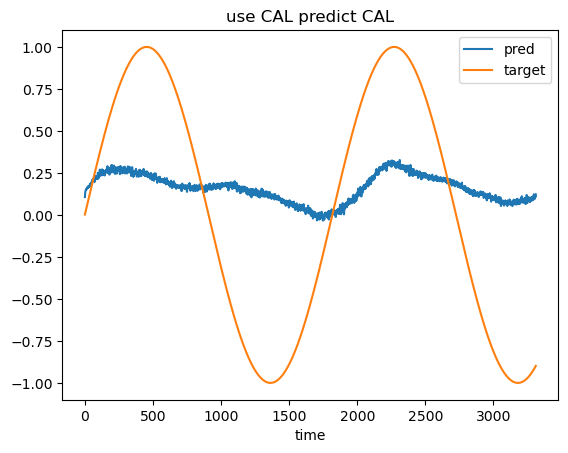

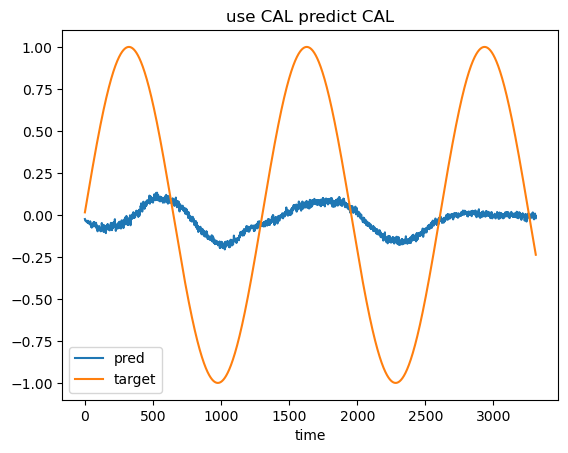

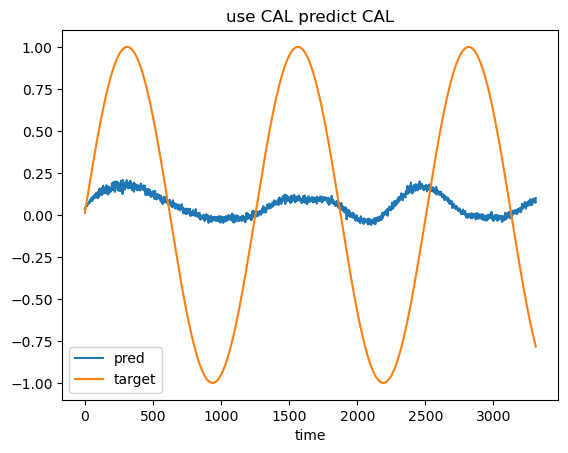

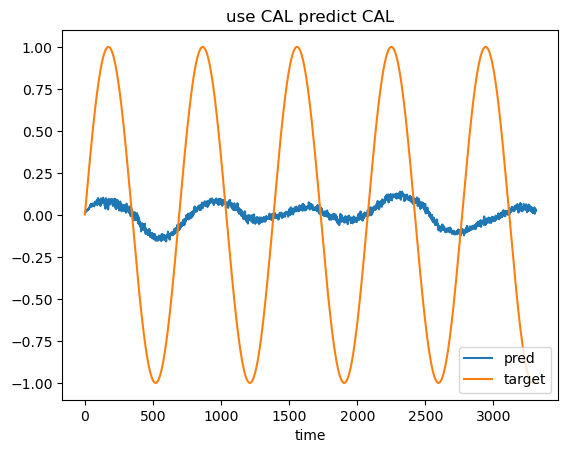

In [19]:
####### this code block uses the LSTM model based on train: calcium_data, test: calcium_data
# prediction calcium visualization (train on calcium - calcium)
calcium_data = dataset["worm0"]["calcium_data"].float()
target = calcium_data
prediction = model(calcium_data)
plt.plot(prediction[:, 0].detach().numpy())
plt.plot(target[:, 0])
plt.title("use CAL predict CAL")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 5].detach().numpy())
plt.plot(target[:, 5])
plt.title("use CAL predict CAL")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 10].detach().numpy())
plt.plot(target[:, 10])
plt.title("use CAL predict CAL")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 20].detach().numpy())
plt.plot(target[:, 20])
plt.title("use CAL predict CAL")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 50].detach().numpy())
plt.plot(target[:, 50])
plt.title("use CAL predict CAL")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 100].detach().numpy())
plt.plot(target[:, 100])
plt.title("use CAL predict CAL")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 300].detach().numpy())
plt.plot(target[:, 300])
plt.title("use CAL predict CAL")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

### BiLSTM trial

Start Training!
--------worm No. 0--------
epoch = 0, train_loss = 0.0000, test_loss = 0.0000
epoch = 1, train_loss = -0.0000, test_loss = -0.0000
epoch = 2, train_loss = 0.0000, test_loss = -0.0000
epoch = 3, train_loss = -0.0000, test_loss = 0.0000
epoch = 4, train_loss = -0.0000, test_loss = -0.0000
epoch = 5, train_loss = 0.0000, test_loss = -0.0000
epoch = 6, train_loss = -0.0000, test_loss = -0.0000
epoch = 7, train_loss = 0.0000, test_loss = -0.0000
epoch = 8, train_loss = -0.0000, test_loss = -0.0000
epoch = 9, train_loss = -0.0000, test_loss = -0.0000
epoch = 10, train_loss = -0.0000, test_loss = -0.0000
epoch = 11, train_loss = -0.0000, test_loss = -0.0000
epoch = 12, train_loss = -0.0000, test_loss = -0.0000
epoch = 13, train_loss = -0.0000, test_loss = -0.0000
epoch = 14, train_loss = -0.0000, test_loss = -0.0000
epoch = 15, train_loss = -0.0000, test_loss = -0.0000
epoch = 16, train_loss = -0.0000, test_loss = -0.0000
epoch = 17, train_loss = -0.0000, test_loss = -0.0000
e

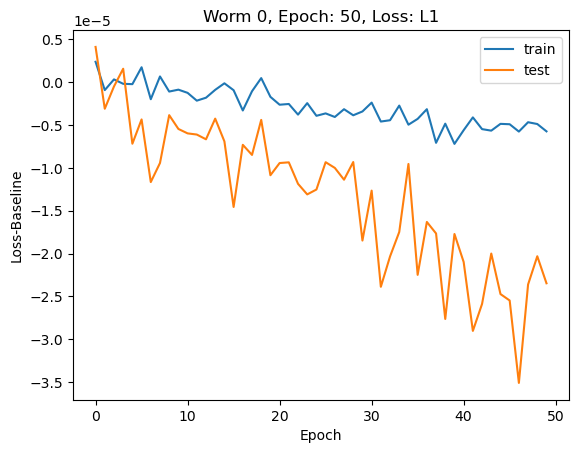

In [44]:
print("Start Training!")
# train
for i in range(len(dataset) - 5):
    print("--------worm " + "No. " + str(i) + "--------")
    train_loader = worm_train[i]
    test_loader = worm_test[i]
    train_base_loss_history = []
    train_pred_loss_history = []
    test_base_loss_history = []
    test_pred_loss_history = []
    for e in range(EPOCH):
        train_base_loss = 0
        train_pred_loss = 0
        test_base_loss = 0
        test_pred_loss = 0
        for X_train, Y_train in train_loader:
            X_train, Y_train = X_train.to(DEVICE), Y_train.to(DEVICE)
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(torch.zeros_like(Y_train), Y_train)
            Y_tr = model(X_train)  # Forward pass.
            loss = criterion(Y_tr, Y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  # Update parameters based on gradients.
            train_base_loss += base.detach().item()
            train_pred_loss += loss.detach().item()
        train_base_loss_history.append(train_base_loss / train_batch_size)
        train_pred_loss_history.append(train_pred_loss / train_batch_size)

        for X_test, Y_test in test_loader:
            X_test, Y_test = X_test.to(DEVICE), Y_test.to(DEVICE)
            optimizer.zero_grad()  # Clear gradients.
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(torch.zeros_like(Y_test), Y_test)
            Y_pred = model(X_test)  # Forward pass.
            loss = criterion(Y_pred, Y_test)
            test_base_loss += base.detach().item()
            test_pred_loss += loss.detach().item()
        test_base_loss_history.append(test_base_loss / test_batch_size)
        test_pred_loss_history.append(test_pred_loss / test_batch_size)

        print("epoch = {}, train_loss = {:.4f}, test_loss = {:.4f}".format(e,
                                                                           train_pred_loss_history[-1] -
                                                                           train_base_loss_history[
                                                                               -1],
                                                                           test_pred_loss_history[-1] -
                                                                           test_base_loss_history[
                                                                               -1]))

    delta_train = [train_pred_loss_history[i] - train_base_loss_history[i] for i in range(len(train_base_loss_history))]
    delta_test = [test_pred_loss_history[i] - test_base_loss_history[i] for i in range(len(test_base_loss_history))]
    plt.plot(delta_train)
    plt.plot(delta_test)
    plt.legend(["train", "test"])
    plt.ylabel("Loss-Baseline")
    plt.xlabel("Epoch")
    plt.title("Worm " + str(i) + ", Epoch: " + str(EPOCH) + ", Loss: L1")
    plt.show()

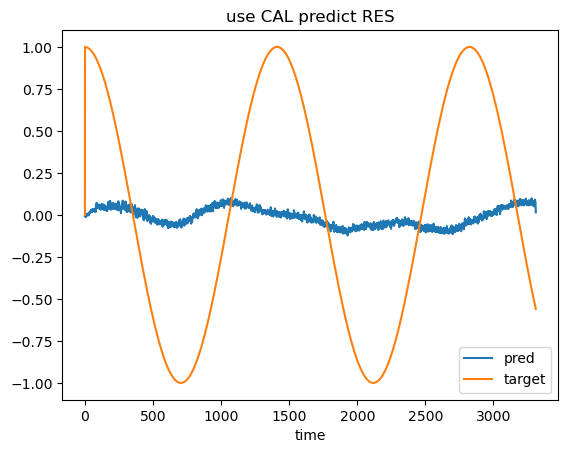

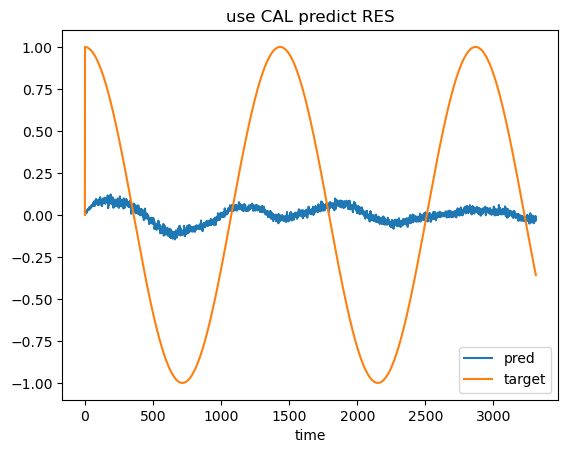

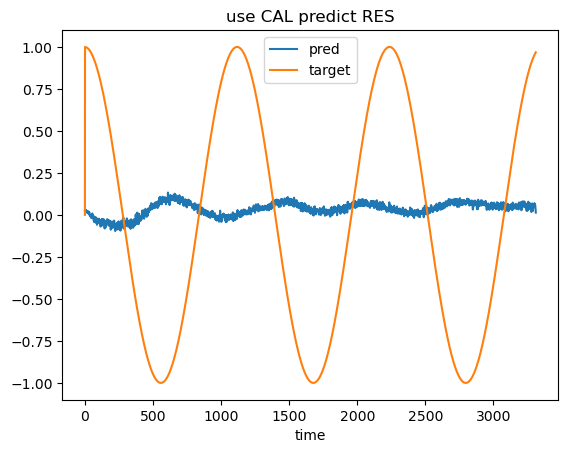

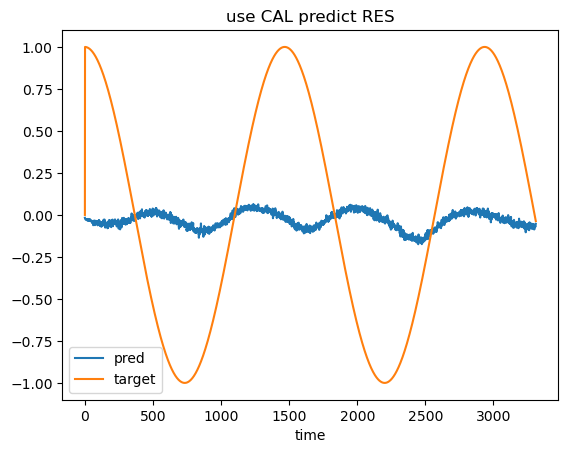

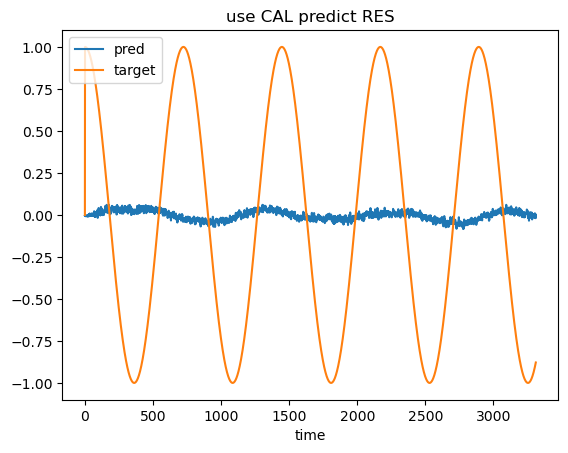

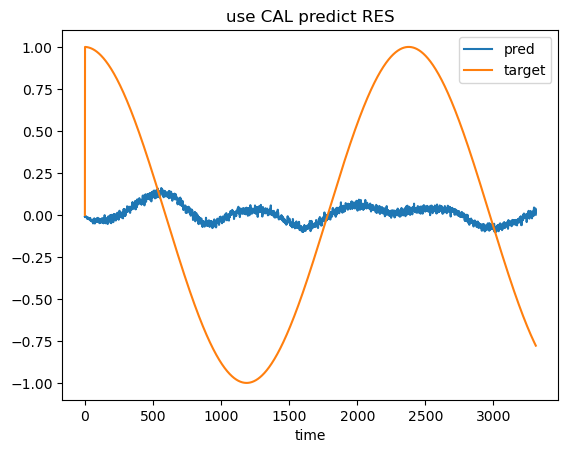

In [45]:
# prediction residual visualization (train on calcium - residual)
calcium_data = dataset["worm0"]["calcium_data"].float()
residual_calcium = dataset["worm0"]["residual_calcium"].float()
prediction = model(calcium_data)
plt.plot(prediction[:, 0].detach().numpy())
plt.plot(residual_calcium[:, 0])
plt.title("use CAL predict RES")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 10].detach().numpy())
plt.plot(residual_calcium[:, 10])
plt.title("use CAL predict RES")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 50].detach().numpy())
plt.plot(residual_calcium[:, 50])
plt.title("use CAL predict RES")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 100].detach().numpy())
plt.plot(residual_calcium[:, 100])
plt.title("use CAL predict RES")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 200].detach().numpy())
plt.plot(residual_calcium[:, 200])
plt.title("use CAL predict RES")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()

plt.plot(prediction[:, 300].detach().numpy())
plt.plot(residual_calcium[:, 300])
plt.title("use CAL predict RES")
plt.legend(["pred", "target"])
plt.xlabel("time")
plt.show()